In [26]:
import gzip
import numpy as np
import urllib
import matplotlib.pyplot as plt
import random
from collections import defaultdict, Counter
import datetime
import tqdm


In [27]:
def readGz(f):
  for l in tqdm.tqdm_notebook(gzip.open(f), total=1689188):
    yield eval(l)
data = list(readGz("reviews_Electronics_5.json.gz"))

In [28]:
random.seed(42)
random.shuffle(data)
train_length = 840000
train_data = data[:train_length]
validation_data = data[train_length:]

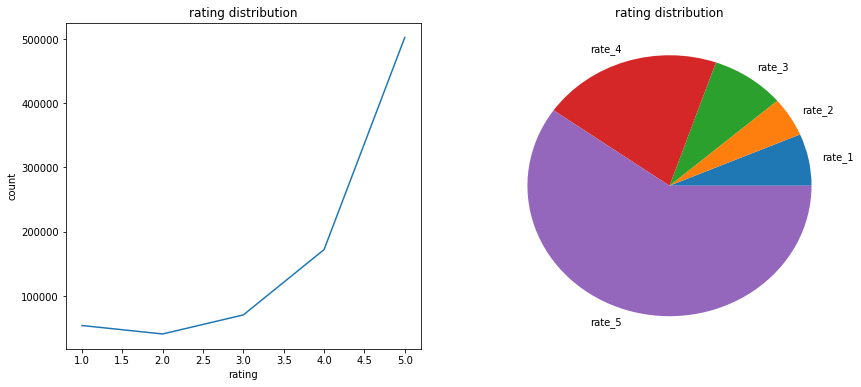

In [29]:
# rating's distribution
# it seems most people just give 5 scores for electronics product.
rating = Counter(emlt["overall"] for emlt in train_data)
xs, ys = zip(*sorted(rating.items()))
plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.plot(xs, ys)
plt.title("rating distribution")
plt.xlabel("rating")
plt.ylabel("count")
plt.subplot(122)
plt.title("rating distribution")
plt.pie(ys, labels=list(map(lambda x: "rate_%d" % x, xs)))
plt.show()

In [30]:
def avg(v):
    return sum(v) / len(v)
def time_sequence_exploratory(time_split, plotID=111, title="", win_size=1, gap=1, shift=0):
    # using strftiem to split the rate depending on the time_split.
    # using win_size and gap to smooth the data
    year_month_rates = defaultdict(list)
    for elmt in train_data:
        date = datetime.datetime.utcfromtimestamp(int(elmt["unixReviewTime"])).strftime(time_split)
        year_month_rates[date].append(elmt["overall"])
    
    year_month_average = {k: sum(v) / len(v) for k, v in year_month_rates.items()}
    raw_xs = sorted(year_month_average.keys())[shift:]
    raw_ys = [year_month_average[x] for x in raw_xs][shift:]
    
    xs = raw_xs[::gap]
    ys = list(map(avg, zip(*[raw_ys[i::gap] for i in range(win_size)])))

    plt.subplot(plotID)

    plt.plot(xs[:len(ys)], ys)
        
    if len(xs) > 15:
        # too many label to be shown
        plt.xticks(xs[::len(xs) // 15], rotation=45)
    if 15 > len(xs) > 10:
        plt.xticks(rotation=45)
    plt.title(title)
    return xs, ys

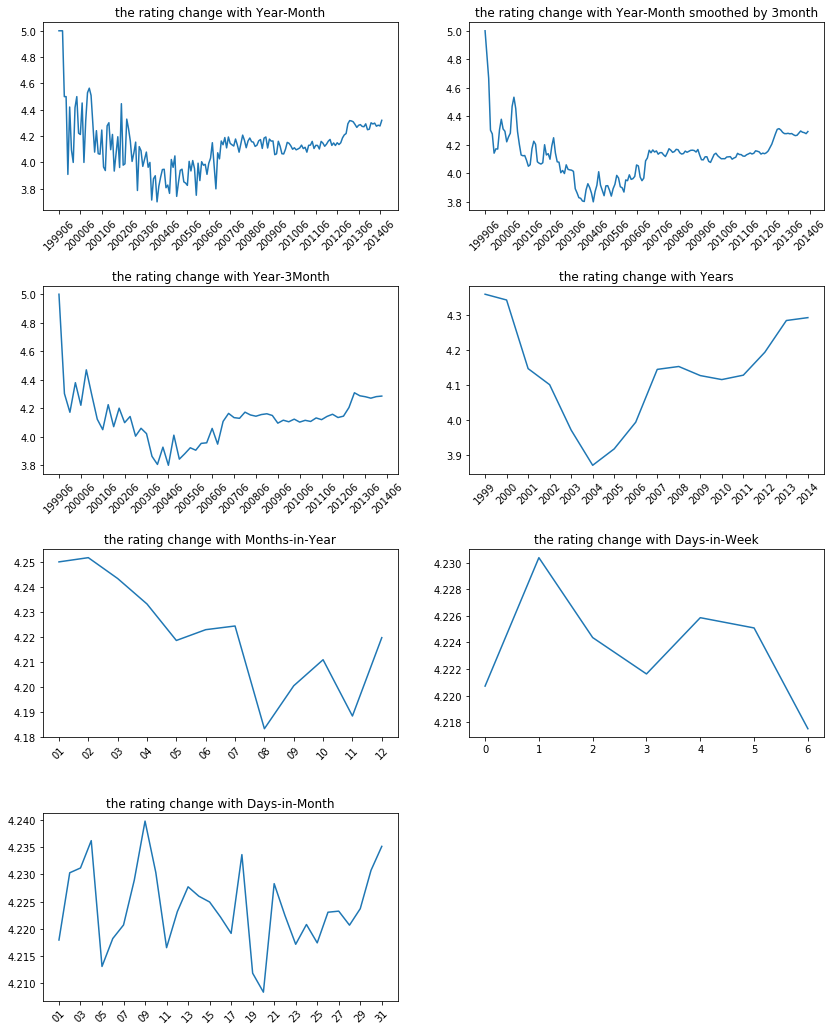

In [31]:
# the rating may have some relation with the time sequence

plt.figure(figsize=(14, 18))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.4)
params = [
    ["%Y%m", 421, "the rating change with Year-Month", 1, 1, 0],
    ["%Y%m", 422, "the rating change with Year-Month smoothed by 3month", 3, 1, 0],
    ["%Y%m", 423, "the rating change with Year-3Month", 3, 3, 0],
    ["%Y", 424, "the rating change with Years", 1, 1, 0],
    ["%m", 425, "the rating change with Months-in-Year", 1, 1, 0],
    ["%w", 426, "the rating change with Days-in-Week", 1, 1, 0],
    ["%d", 427, "the rating change with Days-in-Month", 1, 1, 0],
]
ys_record = []

for param in tqdm.tqdm_notebook(params):
    xs, ys = time_sequence_exploratory(*param)
    ys_record.append(dict(zip(xs, ys)))

The rating vary among months and years.

In [32]:
def user_item_rating_exploratory(time_split, plotID=111, title="", win_size=1, gap=1, shift=0):
    # using strftiem to split the rate depending on the time_split.
    # using win_size and gap to smooth the data
    year_month_rates = defaultdict(list)
    for elmt in train_data:
        date = datetime.datetime.utcfromtimestamp(int(elmt["unixReviewTime"])).strftime(time_split)
        year_month_rates[date].append(elmt["overall"])
    
    year_month_avgrate = {k: sum(v) / len(v) for k, v in year_month_rates.items()}
    raw_xs = sorted(year_month_avgrate.keys())[shift:]
    raw_ys = [year_month_avgrate[x] for x in raw_xs][shift:]
    
    xs = raw_xs[::gap]
    def avg(v):
        return sum(v) / len(v)
    ys = list(map(avg, zip(*[raw_ys[i::gap] for i in range(win_size)])))

    plt.subplot(plotID)
    plt.plot(xs[:len(ys)], ys)
    if len(xs) > 15:
        # too many label to be shown
        plt.xticks(xs[::len(xs) // 15], rotation=45)
    if 15 > len(xs) > 10:
        plt.xticks(rotation=45)
    plt.title(title)

In [33]:
# I guess that user may give lower scores after he or she buy more electronic products.
import bisect
user_time_rate = defaultdict(list)
item_time_rate = defaultdict(list)
user_nitem = defaultdict(int)
item_nuser = defaultdict(int)
for elmt in train_data:
    user = elmt["reviewerID"]
    time = elmt["unixReviewTime"]
    item = elmt["asin"]
    rate = elmt["overall"]
    user_nitem[user] += 1
    item_nuser[item] += 1
    bisect.insort(user_time_rate[user], (time, rate))
    bisect.insort(item_time_rate[item], (time, rate))

In [34]:
# in train data set
print("in train data set")
print("the user's num in train_data: ", len(user_nitem)) 
print("the item's num in train_data: ", len(item_nuser))
print("the user %s has bought %d products" % sorted(user_nitem.items(), key=lambda x: x[1])[-1])
print("the most popular product is %s which has been bought %d times" %
     sorted(item_nuser.items(), key=lambda x: x[1])[-1])
print("in average, every user bought %d items" % (train_length / len(user_nitem)))
print("in average, every product was bought %d times" % (train_length / len(item_nuser)))
total_avg_rate = sum(emlt["overall"] for emlt in train_data) / len(train_data)
print("the total avg rate is %d" % total_avg_rate)

in train data set
the user's num in train_data:  189619
the item's num in train_data:  62516
the user ADLVFFE4VBT8 has bought 221 products
the most popular product is B007WTAJTO which has been bought 2477 times
in average, every user bought 4 items
in average, every product was bought 13 times
the total avg rate is 4


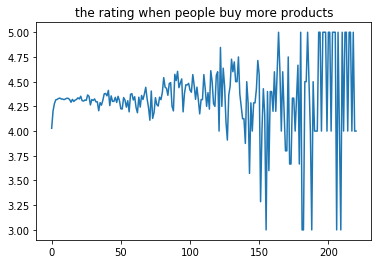

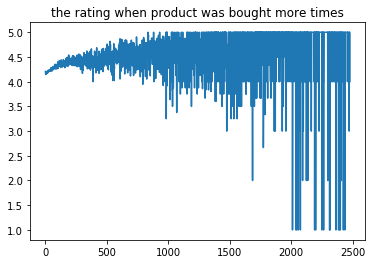

In [35]:
def myzip(matrix, threshold=0):
    res = []
    for line in matrix:
        if len(line) < threshold:
            continue
        for i, x in enumerate(line):
            if i == len(res):
                res.append([])
            res[i].append(x)
    return res
def avg2(xs):
    return sum([x[1] for x in xs]) / len(xs)

time_rate = myzip(user_time_rate.values())
ys = list(map(avg2, time_rate))
plt.plot(ys)
plt.title("the rating when people buy more products")
plt.show()

time_rate2 = myzip(item_time_rate.values())
def avg2(xs):
    return sum([x[1] for x in xs]) / len(xs)
ys = list(map(avg2, time_rate2))
plt.plot(ys)
plt.title("the rating when product was bought more times")
plt.show()

Seems the first product bought by one user usually get lower score <br>


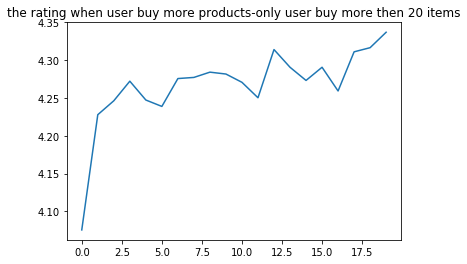

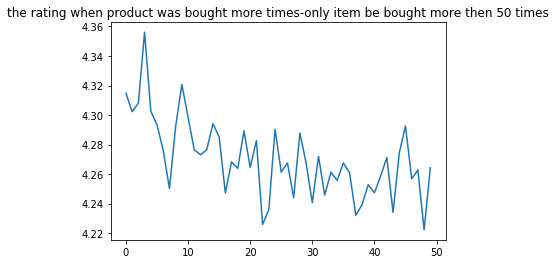

In [40]:
thres = 20
time_rate = myzip(user_time_rate.values(), thres)
ys = list(map(avg2, time_rate))
plt.plot(ys[:20])
plt.title("the rating when user buy more products-only user buy more then %d items" % thres)
plt.show()

thres = 50
time_rate2 = myzip(item_time_rate.values(), thres)
def avg2(xs):
    return sum([x[1] for x in xs]) / len(xs)
ys = list(map(avg2, time_rate2))
plt.plot(ys[:50])
plt.title("the rating when product was bought more times-only item be bought more then %d times" % thres)
plt.show()


In [38]:
# using some kinds of naive solution to solve the problem.
# some kinds of baseline solution
def compute_MSE(predictions,y):
    return np.dot((predictions-y),(predictions-y).T)/float(len(y))


def predict_total_avg_based(emlt):
    return total_avg_rate

def predict_year_avg_based(emlt):
    years = datetime.datetime.utcfromtimestamp(int(elmt["unixReviewTime"])).strftime("%Y")
    return ys_record[3][years]

def predict_year_month_avg_based(emlt):
    ym = datetime.datetime.utcfromtimestamp(int(elmt["unixReviewTime"])).strftime("%Y%m")
    return ys_record[0][ym]

def predict_year_month3_avg_based(emlt):
    ym = datetime.datetime.utcfromtimestamp(int(elmt["unixReviewTime"])).strftime("%Y%m")
    return ys_record[1][ym]

y_validation = np.array([elmt['overall'] for elmt in validation_data])
predictions = [predict_total_avg_based(elmt) for elmt in validation_data]
MSE = compute_MSE(predictions, y_validation)
print("the total avg based MSE is ", MSE)

predictions = [predict_year_avg_based(elmt) for elmt in validation_data]
MSE = compute_MSE(predictions, y_validation)
print("the year avg based MSE is ", MSE)

predictions = [predict_year_month_avg_based(elmt) for elmt in validation_data]
MSE = compute_MSE(predictions, y_validation)
print("the year month avg based MSE is ", MSE)

predictions = [predict_year_month3_avg_based(elmt) for elmt in validation_data]
MSE = compute_MSE(predictions, y_validation)
print("the year month avg with 3 month smooth based MSE is ", MSE)

the total avg based MSE is  1.406073834898793
the year avg based MSE is  1.4099594202501695
the year month avg based MSE is  1.408051059690282
the year month avg with 3 month smooth based MSE is  1.4092993432965546
